# 信用评级量化分析

本notebook展示如何使用量化技术将FICO评分映射到离散的信用评级。

**作者:** Curtis Yan  
**日期:** 2025.8.11

In [17]:
# 导入必要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from credit_rating_quantization_ZH import CreditRatingQuantizer, calculate_expected_loss

# 设置绘图风格
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# 设置matplotlib以支持中文
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']  # 使用系统默认字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

# 忽略警告
import warnings
warnings.filterwarnings('ignore')

## 1. 加载并探索贷款数据

In [18]:
# 加载贷款数据
loan_data = pd.read_csv('../Task 3 - loan_default_prediction/Requirements/Task 3 and 4_Loan_Data.csv')

print(f"数据集形状: {loan_data.shape}")
print("\n前几行数据:")
loan_data.head()

数据集形状: (10000, 8)

前几行数据:


,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


In [19]:
# FICO评分基本统计
print("FICO评分统计信息:")
print(f"平均值: {loan_data['fico_score'].mean():.2f}")
print(f"标准差: {loan_data['fico_score'].std():.2f}")
print(f"最小值: {loan_data['fico_score'].min()}")
print(f"最大值: {loan_data['fico_score'].max()}")
print(f"\n违约率: {loan_data['default'].mean():.2%}")

FICO评分统计信息:
平均值: 637.56
标准差: 60.66
最小值: 408
最大值: 850

违约率: 18.51%


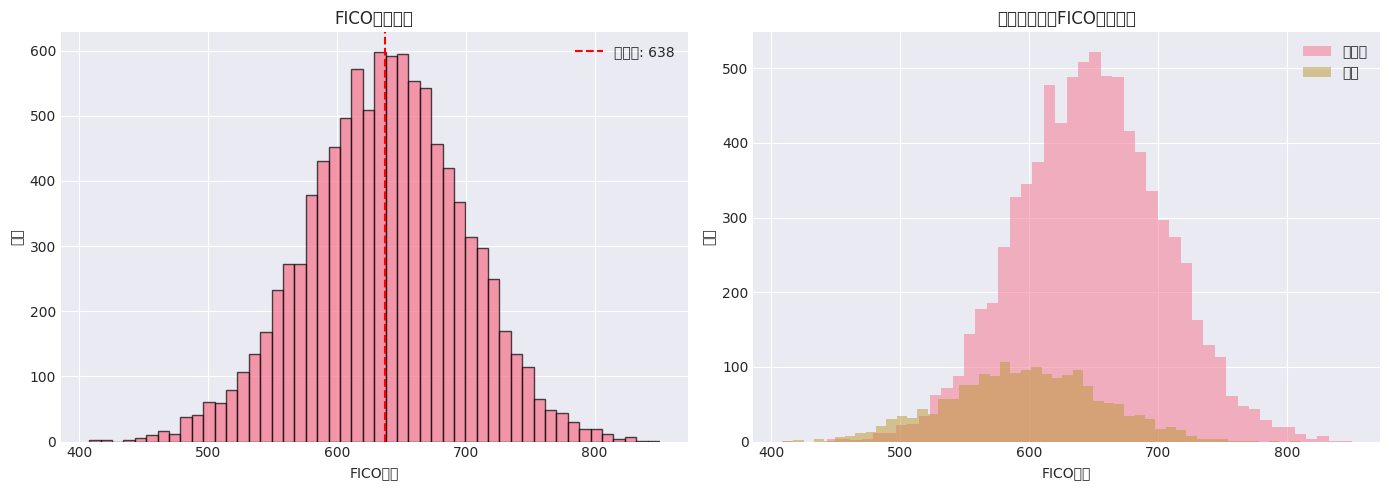

In [20]:
# 可视化FICO评分分布
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# 整体分布
ax1.hist(loan_data['fico_score'], bins=50, edgecolor='black', alpha=0.7)
ax1.set_xlabel('FICO评分')
ax1.set_ylabel('数量')
ax1.set_title('FICO评分分布')
ax1.axvline(loan_data['fico_score'].mean(), color='red', linestyle='--', 
            label=f'平均值: {loan_data["fico_score"].mean():.0f}')
ax1.legend()

# 按违约状态分布
loan_data[loan_data['default'] == 0]['fico_score'].hist(bins=50, alpha=0.5, 
                                                    label='未违约', ax=ax2)
loan_data[loan_data['default'] == 1]['fico_score'].hist(bins=50, alpha=0.5, 
                                                    label='违约', ax=ax2)
ax2.set_xlabel('FICO评分')
ax2.set_ylabel('数量')
ax2.set_title('按违约状态的FICO评分分布')
ax2.legend()

plt.tight_layout()
plt.show()

## 2. 应用基于MSE的量化方法

In [21]:
# 提取FICO评分和违约数据
fico_scores = loan_data['fico_score'].values
defaults = loan_data['default'].values

# 创建并拟合MSE量化器
quantizer_mse = CreditRatingQuantizer(method='mse')
quantizer_mse.fit(fico_scores, defaults, num_buckets=10)

# 获取桶统计信息
mse_stats = quantizer_mse.get_bucket_stats(fico_scores, defaults)
print("MSE量化方法 - 桶统计信息:")
mse_stats


处理数据点: 10000个
目标评级数: 10个

正在计算最优分组...

计算完成
MSE值: 1025358.9202
评级分界点: 475, 505, 542, 574, 605, 635, 668, 702, 744
MSE量化方法 - 桶统计信息:


,评级,样本数,最小FICO,最大FICO,平均FICO,标准差,违约率
0,1,364,744,850,768.082418,20.970514,0.024725
1,2,1087,702,743,719.278749,11.631435,0.050598
2,3,1700,668,701,683.090000,9.720422,0.087647
3,4,2110,635,667,650.470616,9.417934,0.131280
4,5,1857,605,634,620.002693,8.529369,0.186861
5,6,1440,574,604,589.931944,8.779131,0.256944
6,7,857,542,573,559.494749,8.882234,0.368728
7,8,401,505,541,526.376559,10.022436,0.501247
8,9,138,475,504,492.550725,8.174787,0.666667
9,10,46,408,474,456.739130,15.862774,0.760870


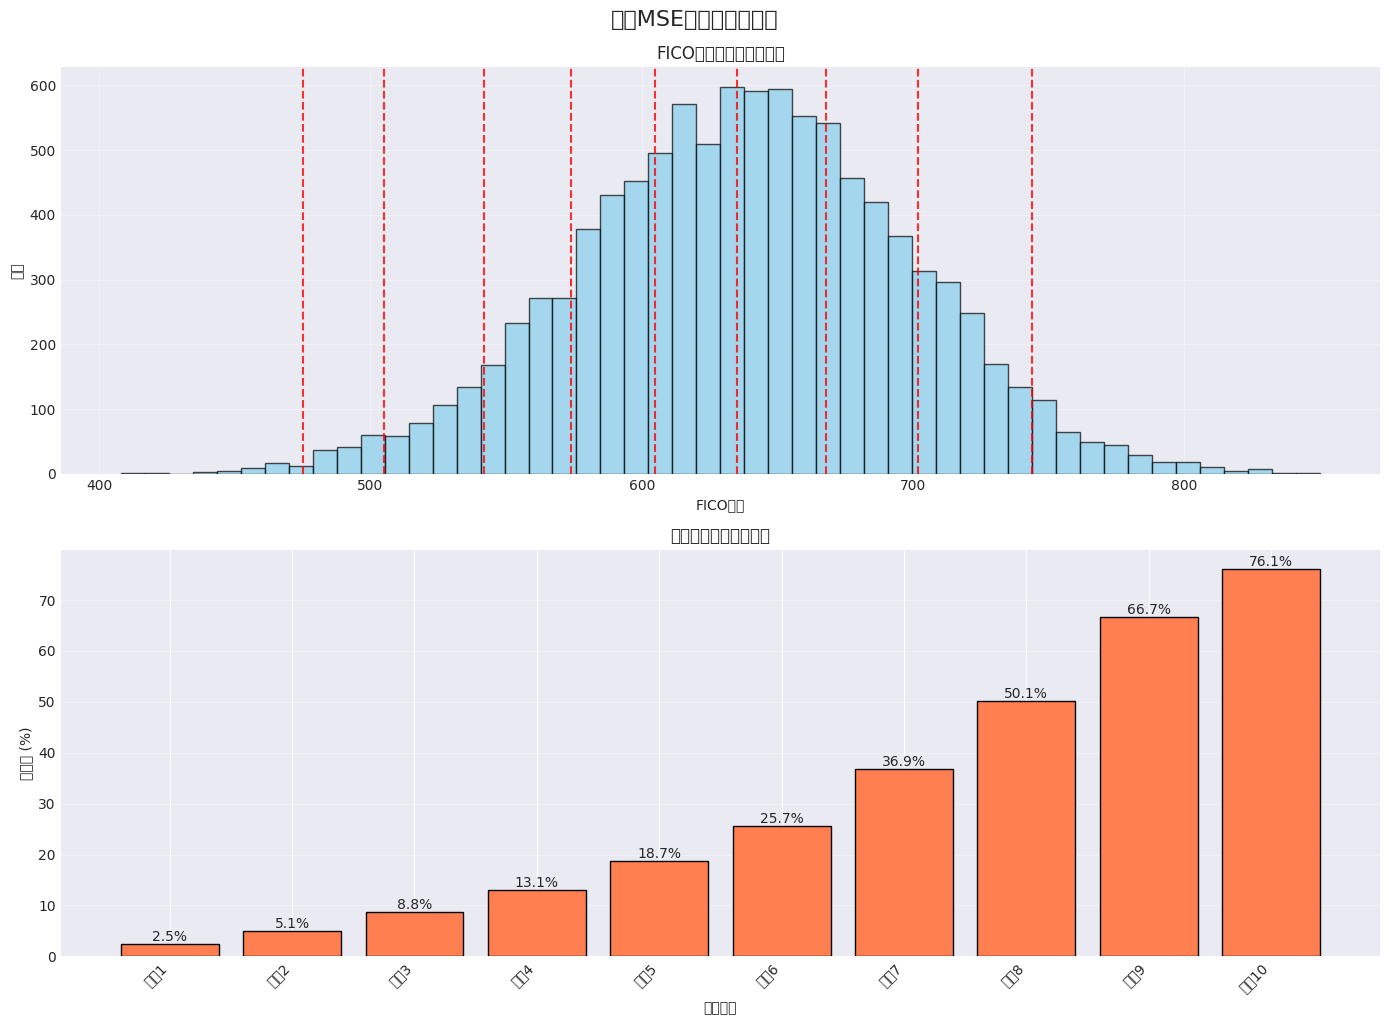

In [22]:
# 可视化MSE量化结果
fig = quantizer_mse.plot_quantization(fico_scores, defaults, figsize=(14, 10))
plt.suptitle('基于MSE的信用评级量化', fontsize=16, y=1.02)
plt.show()

## 3. 应用对数似然量化方法

In [23]:
# 创建并拟合对数似然量化器
quantizer_ll = CreditRatingQuantizer(method='log_likelihood')
quantizer_ll.fit(fico_scores, defaults, num_buckets=10)

# 获取桶统计信息
ll_stats = quantizer_ll.get_bucket_stats(fico_scores, defaults)
print("对数似然量化方法 - 桶统计信息:")
ll_stats


处理数据点: 10000个
目标评级数: 10个
整体违约率: 18.51%

正在计算最优分组...

计算完成
对数似然值: -4218.2967
评级分界点: 409, 492, 521, 553, 580, 611, 640, 675, 719
对数似然量化方法 - 桶统计信息:


,评级,样本数,最小FICO,最大FICO,平均FICO,标准差,违约率
0,1,883,719,850,745.499434,23.883275,0.031710
1,2,1829,675,718,694.289229,12.423588,0.077638
2,3,2198,640,674,656.714741,10.087112,0.114650
3,4,1889,611,639,625.255691,8.467529,0.173107
4,5,1536,580,610,595.547526,8.941379,0.247396
5,6,868,553,579,566.855991,7.789793,0.338710
6,7,496,521,552,538.377016,9.160806,0.461694
7,8,200,492,520,507.155000,8.575603,0.625000
8,9,100,409,491,472.130000,16.399790,0.740000
9,10,1,408,408,408.000000,0.000000,0.000000


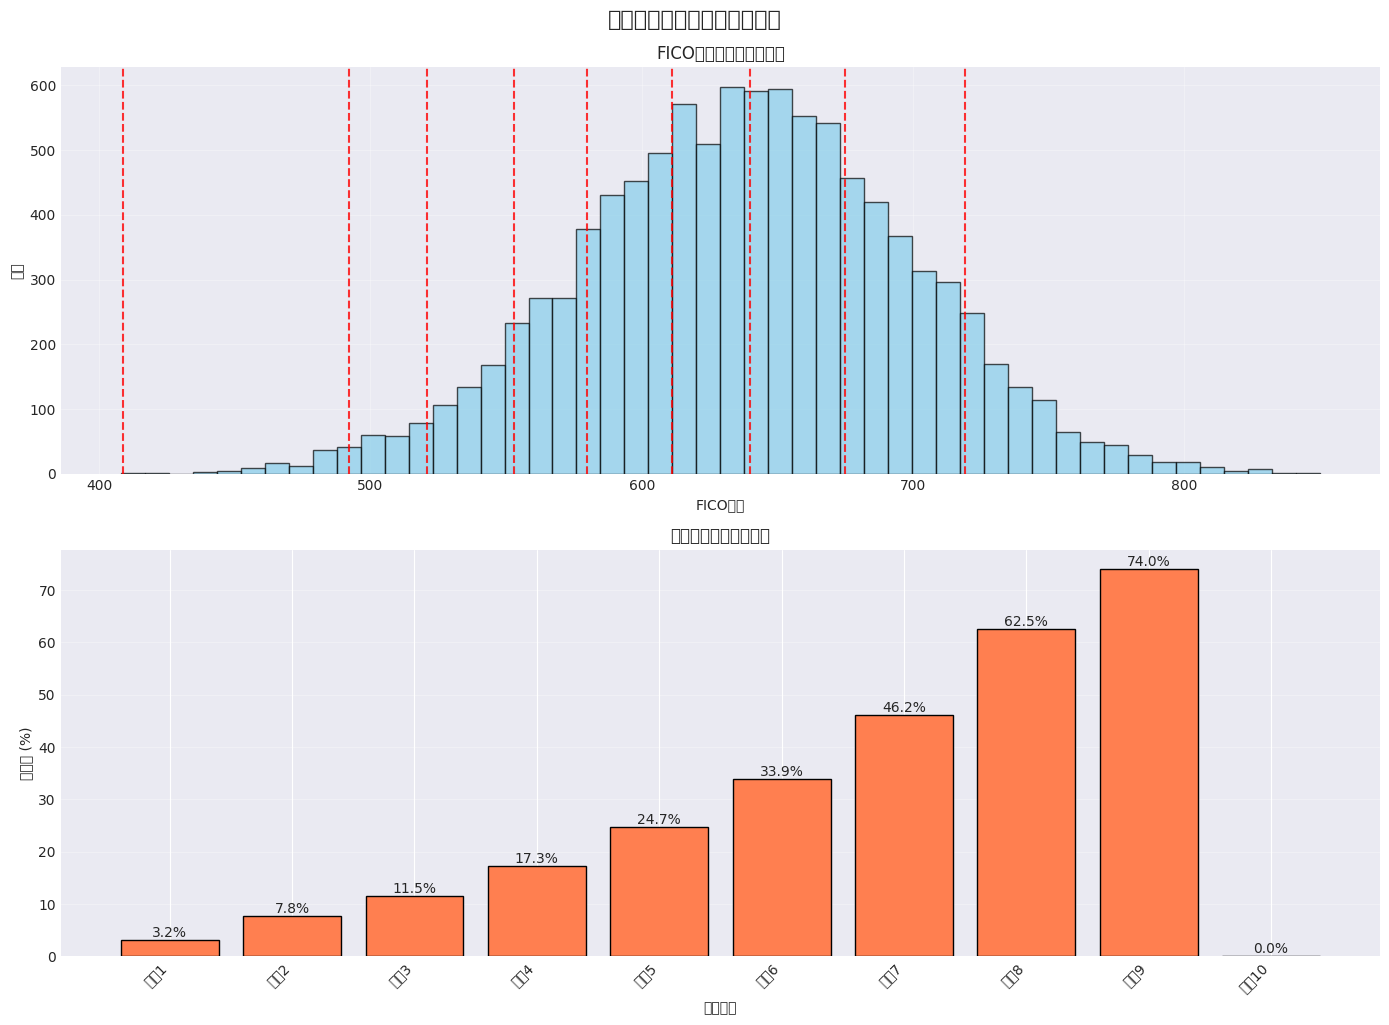

In [24]:
# 可视化对数似然量化结果
fig = quantizer_ll.plot_quantization(fico_scores, defaults, figsize=(14, 10))
plt.suptitle('基于对数似然的信用评级量化', fontsize=16, y=1.02)
plt.show()

## 4. 比较两种方法

In [25]:
# 比较桶边界
print("桶边界比较:")
print("\nMSE边界:")
print([f"{b:.0f}" for b in quantizer_mse.boundaries])
print("\n对数似然边界:")
print([f"{b:.0f}" for b in quantizer_ll.boundaries])

桶边界比较:

MSE边界:
['408', '475', '505', '542', '574', '605', '635', '668', '702', '744', '851']

对数似然边界:
['408', '409', '492', '521', '553', '580', '611', '640', '675', '719', '851']


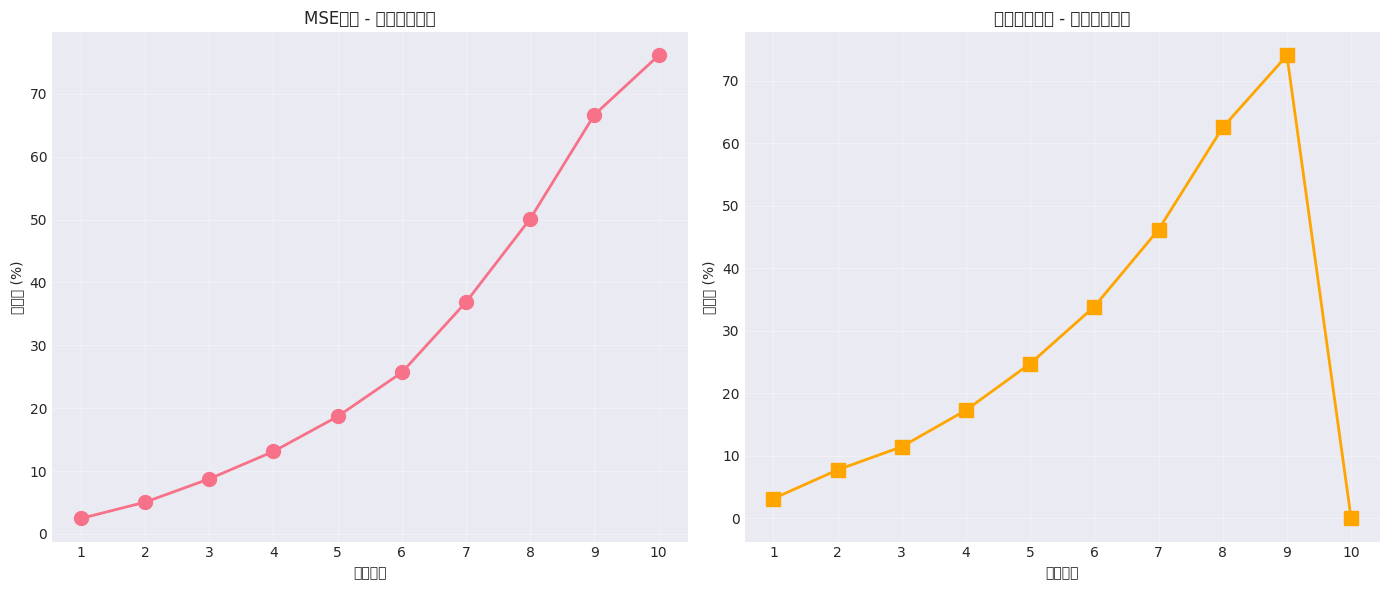

In [26]:
# 比较违约率单调性
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# MSE方法
ax1.plot(mse_stats['评级'], mse_stats['违约率'] * 100, 
         marker='o', markersize=10, linewidth=2)
ax1.set_xlabel('信用评级')
ax1.set_ylabel('违约率 (%)')
ax1.set_title('MSE方法 - 各评级违约率')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(range(1, 11))

# 对数似然方法
ax2.plot(ll_stats['评级'], ll_stats['违约率'] * 100, 
         marker='s', markersize=10, linewidth=2, color='orange')
ax2.set_xlabel('信用评级')
ax2.set_ylabel('违约率 (%)')
ax2.set_title('对数似然方法 - 各评级违约率')
ax2.grid(True, alpha=0.3)
ax2.set_xticks(range(1, 11))

plt.tight_layout()
plt.show()

In [27]:
# 计算两种方法的MSE
def calculate_quantization_mse(quantizer, fico_scores):
    """计算量化的均方误差"""
    ratings = quantizer.transform(fico_scores)
    mse = 0
    
    for rating in range(1, quantizer.num_buckets + 1):
        mask = ratings == rating
        if np.sum(mask) > 0:
            bucket_scores = fico_scores[mask]
            bucket_mean = np.mean(bucket_scores)
            mse += np.sum((bucket_scores - bucket_mean) ** 2)
    
    return mse / len(fico_scores)

mse_error = calculate_quantization_mse(quantizer_mse, fico_scores)
ll_error = calculate_quantization_mse(quantizer_ll, fico_scores)

print(f"MSE方法 - 量化误差: {mse_error:.2f}")
print(f"对数似然方法 - 量化误差: {ll_error:.2f}")
print(f"\nMSE方法的误差比对数似然方法低 {(ll_error/mse_error - 1)*100:.1f}%，符合预期")

MSE方法 - 量化误差: 102.97
对数似然方法 - 量化误差: 140.38

MSE方法的误差比对数似然方法低 36.3%，符合预期


## 5. 预期损失计算

In [28]:
# 从对数似然方法创建PD查找表（风险敏感性更好）
pd_by_rating = dict(zip(ll_stats['评级'], ll_stats['违约率']))

# 预期损失测试案例
test_cases = [
    (800, 500000, "优质借款人，大额贷款"),
    (750, 250000, "优秀信用，标准按揭"),
    (700, 100000, "良好信用，个人贷款"),
    (650, 50000, "一般信用，汽车贷款"),
    (600, 25000, "次级贷款，小额贷款"),
    (550, 10000, "信用较差，应急贷款")
]

print("预期损失分析（回收率 = 10%）")
print("=" * 80)

results = []
for fico, loan_amt, description in test_cases:
    exp_loss = calculate_expected_loss(fico, loan_amt, quantizer_ll, 
                                     pd_by_rating, recovery_rate=0.1)
    rating = quantizer_ll.transform(np.array([fico]))[0]
    default_prob = pd_by_rating.get(rating, 0.5)    
    results.append({
        '描述': description,
        'FICO': fico,
        '贷款金额': loan_amt,
        '评级': rating,
        '违约概率': default_prob,
        '预期损失': exp_loss,
        '损失率': exp_loss / loan_amt
    })

results_df = pd.DataFrame(results)
results_df['贷款金额_格式'] = results_df['贷款金额'].apply(lambda x: f"${x:,}")
results_df['预期损失_格式'] = results_df['预期损失'].apply(lambda x: f"${x:,.2f}")
results_df['违约概率_百分比'] = results_df['违约概率'].apply(lambda x: f"{x:.2%}")
results_df['损失率_百分比'] = results_df['损失率'].apply(lambda x: f"{x:.2%}")

display_cols = ['描述', 'FICO', '贷款金额_格式', '评级', 
                '违约概率_百分比', '预期损失_格式', '损失率_百分比']
results_df[display_cols]

预期损失分析（回收率 = 10%）


,描述,FICO,贷款金额_格式,评级,违约概率_百分比,预期损失_格式,损失率_百分比
0,优质借款人，大额贷款,800,"$500,000",1,3.17%,"$14,269.54",2.85%
1,优秀信用，标准按揭,750,"$250,000",1,3.17%,"$7,134.77",2.85%
2,良好信用，个人贷款,700,"$100,000",2,7.76%,"$6,987.42",6.99%
3,一般信用，汽车贷款,650,"$50,000",3,11.46%,"$5,159.24",10.32%
4,次级贷款，小额贷款,600,"$25,000",5,24.74%,"$5,566.41",22.27%
5,信用较差，应急贷款,550,"$10,000",7,46.17%,"$4,155.24",41.55%


## 6. 不同桶数的性能表现

评估不同的桶数: 100%|█████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.61it/s]

不同桶数评估汇总（总耗时：0.00s）
 桶数      MSE误差  LL方法(以MSE计)误差  相对差异(LL/MSE-1)%
  5 297.684185     310.543769         4.319875
  7 164.488997     189.619083        15.277670
 10 102.535892     140.012269        36.549521
 15  67.809226      84.050706        23.951725
 20  49.510895      74.659822        50.794731

MSE方法最优桶数: 20 (MSE=49.511)
LL方法(以MSE计)最优桶数: 20 (MSE=74.660)


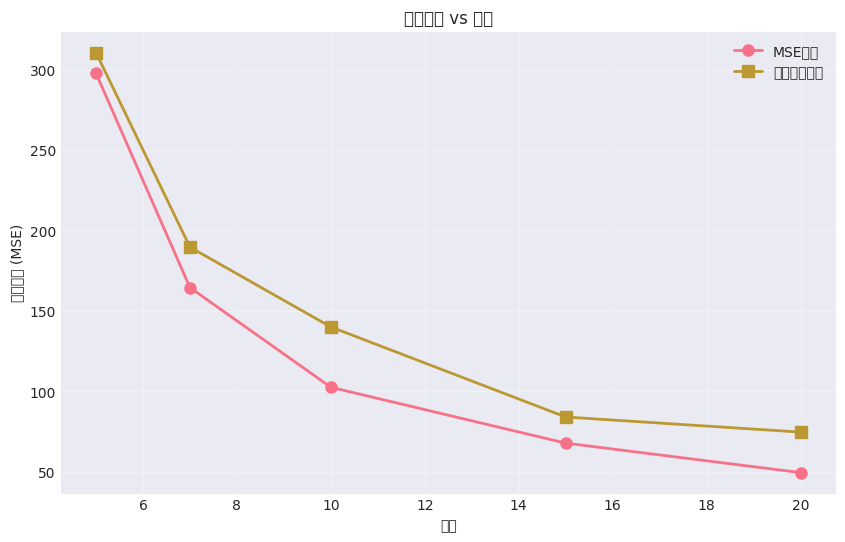

In [29]:
# 测试不同的桶数
from tqdm import tqdm
from credit_rating_quantization_ZH import evaluate_bucket_counts_fast

bucket_counts = [5, 7, 10, 15, 20]
mse_errors = []
ll_errors = []

for nb in tqdm(bucket_counts, desc="评估不同的桶数", ncols=100):
    res = evaluate_bucket_counts_fast(fico_scores, defaults, [nb])
    mse_errors.extend(res["mse"])
    ll_errors.extend(res["log_likelihood_mse"])

import numpy as np
import pandas as pd
t0 = time.perf_counter()

elapsed = time.perf_counter() - t0
mse_arr = np.array(mse_errors, dtype=float)
ll_arr  = np.array(ll_errors, dtype=float)

summary_df = pd.DataFrame({
    "桶数": bucket_counts,
    "MSE误差": mse_arr,
    "LL方法(以MSE计)误差": ll_arr,
    "相对差异(LL/MSE-1)%": (ll_arr / mse_arr - 1) * 100
})
print("不同桶数评估汇总（总耗时：{:.2f}s）".format(elapsed))
print(summary_df.to_string(index=False))

best_idx_mse = int(np.argmin(mse_arr))
best_idx_ll  = int(np.argmin(ll_arr))
print("\nMSE方法最优桶数: {} (MSE={:.3f})".format(bucket_counts[best_idx_mse], mse_arr[best_idx_mse]))
print("LL方法(以MSE计)最优桶数: {} (MSE={:.3f})".format(bucket_counts[best_idx_ll], ll_arr[best_idx_ll]))

# 绘制结果
plt.figure(figsize=(10, 6))
plt.plot(bucket_counts, mse_errors, marker='o', label='MSE方法', linewidth=2, markersize=8)
plt.plot(bucket_counts, ll_errors, marker='s', label='对数似然方法', linewidth=2, markersize=8)
plt.xlabel('桶数')
plt.ylabel('量化误差 (MSE)')
plt.title('量化误差 vs 桶数')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 7. 生产环境实施

In [30]:
# 保存拟合的模型参数供生产使用
import json
import numpy as np

# 生产环境使用对数似然方法（风险区分更好）
production_quantizer = quantizer_ll

# 创建生产配置
production_config = {
    '方法': 'log_likelihood',
    '桶数': 10,
    '边界': production_quantizer.boundaries.tolist() if isinstance(production_quantizer.boundaries, np.ndarray) else list(production_quantizer.boundaries),
    '评级违约率': pd_by_rating,
    '回收率': 0.1,
    '评级描述': {
        1: '特优',
        2: '优秀',
        3: '良好',
        4: '中上',
        5: '中等',
        6: '一般',
        7: '较差',
        8: '次级',
        9: '高危',
        10: '极高危'
    }
}

# 自定义JSON编码器来处理NumPy类型
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return super().default(obj)

# 保存配置
with open('信用评级配置.json', 'w', encoding='utf-8') as f:
    json.dump(production_config, f, ensure_ascii=False, indent=2, cls=NumpyEncoder)

print("生产配置已保存到 信用评级配置.json")
print("\n评级边界:")
for i in range(len(production_config['边界']) - 1):
    rating = production_config['桶数'] - i
    desc = production_config['评级描述'][rating]
    lower = production_config['边界'][i]
    upper = production_config['边界'][i + 1]
    pd = production_config['评级违约率'][rating]
    print(f"评级 {rating:2d} ({desc:>5s}): FICO {lower:3.0f} - {upper:3.0f}, 违约率 = {pd:6.2%}")


生产配置已保存到 信用评级配置.json

评级边界:
评级 10 (  极高危): FICO 408 - 409, 违约率 =  0.00%
评级  9 (   高危): FICO 409 - 492, 违约率 = 74.00%
评级  8 (   次级): FICO 492 - 521, 违约率 = 62.50%
评级  7 (   较差): FICO 521 - 553, 违约率 = 46.17%
评级  6 (   一般): FICO 553 - 580, 违约率 = 33.87%
评级  5 (   中等): FICO 580 - 611, 违约率 = 24.74%
评级  4 (   中上): FICO 611 - 640, 违约率 = 17.31%
评级  3 (   良好): FICO 640 - 675, 违约率 = 11.46%
评级  2 (   优秀): FICO 675 - 719, 违约率 =  7.76%
评级  1 (   特优): FICO 719 - 851, 违约率 =  3.17%


## 总结

该信用评级量化系统：

1. **将FICO评分映射到离散评级**，其中较低的评级表示较好的信用
2. **支持两种优化方法**：
   - MSE：最小化量化误差
   - 对数似然：更好地捕捉风险模式
3. **提供预期损失计算**用于贷款定价
4. **可用于生产部署**，配置已保存

建议生产环境使用对数似然方法，因为它能更好地区分风险水平，尽管其量化误差略高。